In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [2]:
def generate_gaussians_distributions(sep=1, N=500, random_state=42, normalize=True):
    np.random.seed(random_state)
    # Zeros
    X1 = np.random.multivariate_normal(sep*np.array([0.5, 0.5]), [[0.1,-0.085],[-0.085,0.1]], N//2)
    # Ones
    X2 = np.random.multivariate_normal([-0.25, -0.25], [[0.1,0],[0,0.1]], N//2)
    X = np.append(X1, X2, axis=0)
    y = np.append(np.zeros(N//2), np.ones(N//2))
    indexes = np.arange(len(y))
    np.random.shuffle(indexes)
    if normalize:
        X = (X - X.mean(axis=0))/X.std(axis=0)
    else:
        X[:, 0] = X[:, 0]
        X[:, 1] = X[:, 1]
    return X[indexes], y[indexes]

In [3]:
# Primero probar con N = 3000 para ver bien las distribuciones
X, y = generate_gaussians_distributions(sep=2, N = 500, normalize=False, random_state=41)

In [4]:
def plot_boundaries(X_train, y_train, score=None, probability_func=None, degree = None, n_colors = 100, mesh_res = 1000, ax = None):
    X = X_train #np.vstack((X_test, X_train))
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train = y_train.reshape(-1)
    margin_x = (X[:, 0].max() - X[:, 0].min())*0.05
    margin_y = (X[:, 1].max() - X[:, 1].min())*0.05
    x_min, x_max = X[:, 0].min() - margin_x, X[:, 0].max() + margin_x
    y_min, y_max = X[:, 1].min() - margin_y, X[:, 1].max() + margin_y
    hx = (x_max-x_min)/mesh_res
    hy = (y_max-y_min)/mesh_res
    x_domain = np.arange(x_min, x_max, hx)
    y_domain = np.arange(y_min, y_max, hy)
    xx, yy = np.meshgrid(x_domain, y_domain)

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if probability_func is not None:
        if degree is not None:
            polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree)
            Z = probability_func(polynomial_set)[:, 1]
        else:
            Z_aux = probability_func(np.c_[xx.ravel(), yy.ravel()])
            Z = Z_aux[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
    
        cf = ax.contourf(xx, yy, Z, n_colors, vmin=0., vmax=1., cmap=cm, alpha=.8)
        plt.colorbar(cf, ax=ax)
        #plt.colorbar(Z,ax=ax)

        boundary_line = np.where(np.abs(Z-0.5)<0.001)

        ax.scatter(x_domain[boundary_line[1]], y_domain[boundary_line[0]], color='k', alpha=0.5, s=1)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.text(xx.max() - .3, yy.min() + .3, score,
                size=20, horizontalalignment='right')

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=40, marker='o')
 

In [5]:
def plot_boundaries_keras(X_train, y_train, score, probability_func, degree=None, bias=False, h = .02, ax = None, margin=0.5, p_thres=0.5):
    X = X_train
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree, bias=bias)
        Zaux = probability_func(polynomial_set)
    else:
        Zaux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        # Z = Z_aux[:, 1]
    print(Zaux.shape)
    
    if Zaux.shape[1] == 2:
        Z = Zaux[:, 1]
    else:
        Z = Zaux[:, 0]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    cf = ax.contourf(xx, yy, Z, 50, cmap=cm, alpha=.8)
    ax.contour(xx, yy, Z, (p_thres,), colors='k', linewidths=0.5)
    plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=100)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if score is not None:
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=40, horizontalalignment='right')
 

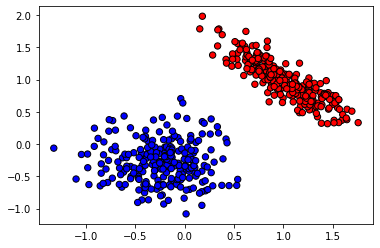

In [6]:
plot_boundaries(X,y)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [9]:
model = Sequential()
# Que pasa si no pongo la función de activación??!
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))
#model.compile('SGD', loss='binary_crossentropy', metric='accuracy')

In [10]:
model.load_weights('roc_initial.hdf5')
model.load_weights('roc_initial_caso_2.hdf5')
# model.load_weights('roc_initial_thres_moved.hdf5')

In [11]:
# X = np.array([[0.8, 0.8], [0, 0.8], [-0.8, -0.8], [0.8, 0.99]])
# y = np.array([0, 0, 1, 1])

In [12]:
predictions = model.predict_proba(X).reshape(-1)

In [13]:
#predictions = np.array([0]*len(y))

In [14]:

eps = 1e-15
bins = 50
predictions_0 = predictions[y==0]
predictions_1 = predictions[y==1]
log_odds_0 = np.log(eps + predictions_0/(1 - predictions_0 + eps))
log_odds_1 = np.log(eps + predictions_1/(1 - predictions_1 + eps))
auROC = roc_auc_score(y, predictions)
fpr, tpr, thres = roc_curve(y, predictions)
precision, recall, pr_thres = precision_recall_curve(y, predictions)
mAP = average_precision_score(y, predictions)
acc_5 = ((predictions>0.5) == y).sum()/len(y)

(41820, 1)


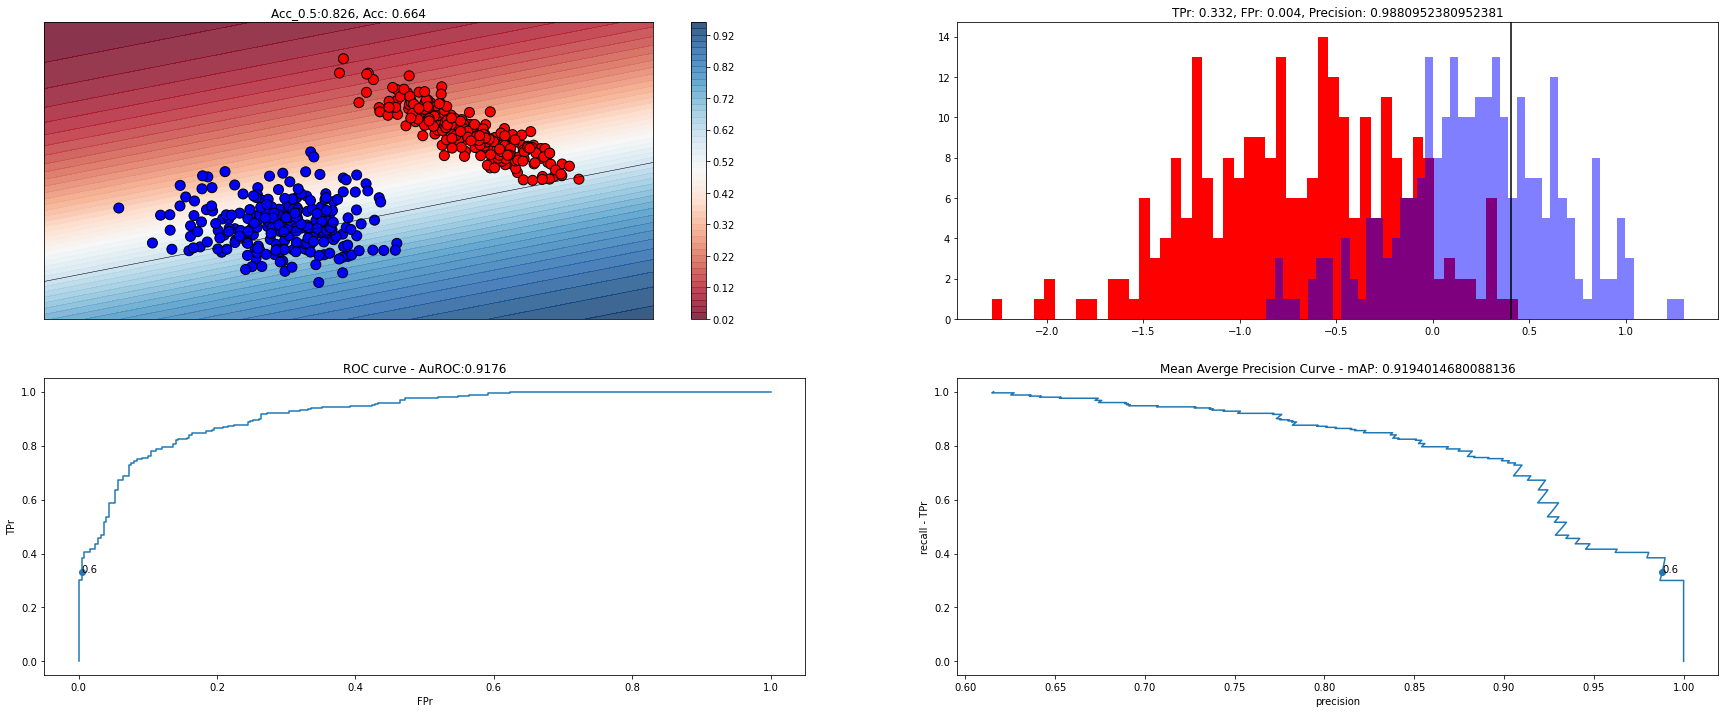

In [15]:
p_thres = 0.6
acc = ((predictions>p_thres) == y).sum()/len(y)
total_positives = (y==1).sum()
TP = (y[(predictions > p_thres)] == 1).sum()/total_positives
FP = (y[(predictions > p_thres)] == 0).sum()/total_positives
Prec = (y[(predictions > p_thres)] == 1).sum()/((y[(predictions > p_thres)] == 1).sum() + (y[(predictions > p_thres)] == 0).sum())


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30,12))
plot_boundaries_keras(X, y, None, model.predict_proba, ax=ax1, p_thres=p_thres)
ax1.set_title(f"Acc_0.5:{acc_5}, Acc: {acc}")
ax2.hist(log_odds_0, bins, color='r')
ax2.hist(log_odds_1, bins, color='b', alpha=0.5)
ax2.axvline(x=np.log(p_thres/(1-p_thres)), c='k')
ax2.set_title(f"TPr: {TP}, FPr: {FP}, Precision: {Prec}")
ax3.plot(fpr, tpr)
ax3.text(FP, TP, f"{p_thres}")
ax3.set_title(f'ROC curve - AuROC:{auROC:.4f}')
ax3.scatter(FP, TP)
ax3.set_xlabel('FPr')
ax3.set_ylabel('TPr')

ax4.plot(precision, recall)
ax4.set_xlabel('precision')
ax4.set_ylabel('recall - TPr')
ax4.set_title(f"Mean Averge Precision Curve - mAP: {mAP}")
ax4.scatter(Prec, TP)
ax4.text(Prec, TP, f"{p_thres}")
plt.show()

Recall = TPr = TP/(TP + FN)   -> Divido por el total de positivos  
FPr = FP/(TP + FN)  -> Divido por el total de positivos  
precision = TP/(TP + FP) -> Divido por todos los que pense que eran positivos

In [16]:
auROC = roc_auc_score(y, [0]*len(y))

In [17]:
auROC

0.5

In [18]:
fpr, tpr, thres

(array([0.   , 0.   , 0.   , 0.004, 0.004, 0.008, 0.008, 0.016, 0.016,
        0.024, 0.024, 0.028, 0.028, 0.032, 0.032, 0.036, 0.036, 0.04 ,
        0.04 , 0.044, 0.044, 0.052, 0.052, 0.056, 0.056, 0.064, 0.064,
        0.072, 0.072, 0.076, 0.076, 0.08 , 0.08 , 0.084, 0.084, 0.092,
        0.092, 0.1  , 0.1  , 0.104, 0.104, 0.112, 0.112, 0.12 , 0.12 ,
        0.136, 0.136, 0.14 , 0.14 , 0.144, 0.144, 0.156, 0.156, 0.16 ,
        0.16 , 0.164, 0.164, 0.184, 0.184, 0.192, 0.192, 0.196, 0.196,
        0.208, 0.208, 0.216, 0.216, 0.224, 0.224, 0.244, 0.244, 0.248,
        0.248, 0.252, 0.252, 0.26 , 0.26 , 0.264, 0.264, 0.272, 0.272,
        0.304, 0.304, 0.32 , 0.32 , 0.332, 0.332, 0.336, 0.336, 0.352,
        0.352, 0.392, 0.392, 0.424, 0.424, 0.428, 0.428, 0.432, 0.432,
        0.464, 0.464, 0.472, 0.472, 0.52 , 0.52 , 0.548, 0.548, 0.564,
        0.564, 0.592, 0.592, 0.624, 0.624, 1.   ]),
 array([0.   , 0.004, 0.3  , 0.3  , 0.384, 0.384, 0.404, 0.404, 0.416,
        0.416, 0.436, 0.4